# Tutorial1: spatial domain identification for DLPFC
This tutorial provides an example of identifying spatial domain for human dorsolateral prefrontal cortex (DLPFC).

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import DisConST
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
import torch
from sklearn.metrics import adjusted_rand_score as ari_score
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Load Data

In [25]:
adata = sc.read_visium(path='Data/DLPFC/151671', count_file= '151671_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
gt = pd.read_csv('Data/DLPFC/151671/151671_truth.txt', sep='\t', header=None, index_col=0)
ctp = pd.read_csv('Data/DLPFC/151671/151671_cell.csv', sep=',',header=0, index_col=0)
adata.obsm['cell_type']=ctp.to_numpy()
gt.columns = ['Ground Truth']
gt[gt.isna()] = "unknown"
adata.obs['Ground Truth'] = gt.loc[adata.obs_names, 'Ground Truth'].astype('category')

## Preprocess

In [27]:
DisConST.generate_spatial_graph(adata, knears=5,self_loops=True)
adata = DisConST.preprocess(adata)
adata

graph includs edges: 20550
Graph construction completed!
Size factor calculation completed!
Data preprocessing completed!


AnnData object with n_obs × n_vars = 4110 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'total_counts_c', 'size_factor_c', 'total_counts_g', 'size_factor_g'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'graph', 'hvg', 'log1p'
    obsm: 'spatial', 'cell_type'

## Train

In [28]:
adata = DisConST.train_DisConST(adata, data='both',size_factors_gene = adata.obs['size_factor_g'],csl_l_g = 0.5, csl_l_c = 0.5, size_factors_cell=adata.obs['size_factor_c'], random_seed=2024, device=used_device)

Negative spots selection completed!
training RNA-seq data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


training cell type proprotion data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


training for fusion...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 649.43it/s]


## Clustering

In [30]:
DisConST.mclust_R(adata, num_cluster=5, used_obsm='STboth', domain_obs='both_label')
adata = adata[adata.obs['Ground Truth']!='unknown']
ari_both=ari_score(adata.obs['Ground Truth'], adata.obs['both_label'])
adata=DisConST.utils.refine_label(adata, key='both_label')
ari_ref=ari_score(adata.obs['Ground Truth'], adata.obs['ref_label'])
ari_ref

fitting ...
  |======================================================================| 100%


0.8391500493229805

## Visualization

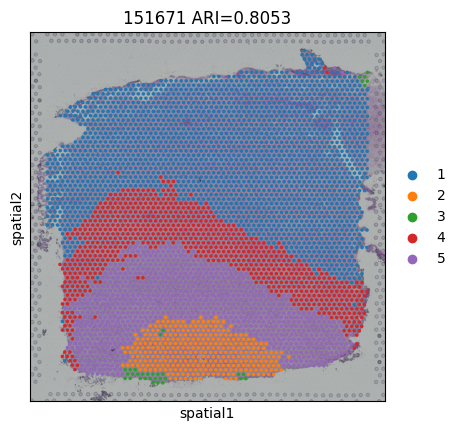

In [33]:
sc.pl.spatial(adata, color='both_label', title=f'151671 ARI={ari_both:.4f}', frameon=True)#before refinement

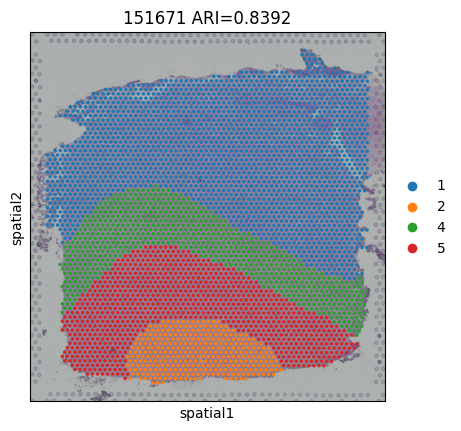

In [34]:
sc.pl.spatial(adata, color='ref_label', title=f'151671 ARI={ari_ref:.4f}', frameon=True)#after refinement

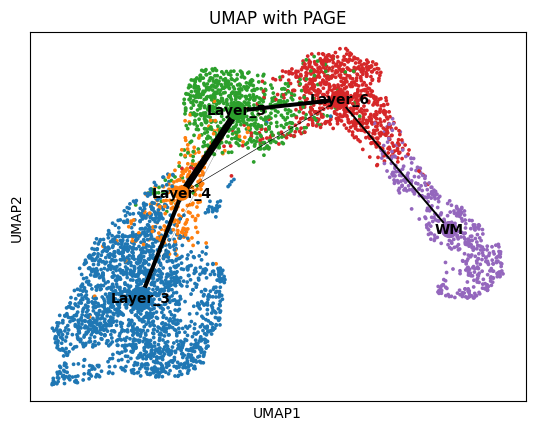

In [35]:
def downstream_task(adata, do_umap, do_paga, paga_label='Ground Truth'):

    if (do_umap):
        sc.pp.neighbors(adata, use_rep='STboth')
        sc.tl.umap(adata)

    if (do_paga):
        if (paga_label in adata.obs):
            adata.obs[paga_label] = adata.obs[paga_label].astype(str)
            sc.pp.neighbors(adata, use_rep='STboth')
            sc.tl.paga(adata, groups=paga_label)
        else:
            print(f'Cannot find target label {paga_label}.')
    
    return adata
adata = downstream_task(adata, do_umap=True, do_paga=True)
pos = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names)
pos["group"] = adata.obs[adata.uns["paga"]["groups"]]
pos = pos.groupby("group", observed=True).mean()
ax=sc.pl.umap(adata, color=['Ground Truth'],legend_loc=None,show=False)
sc.pl.paga(adata, color=['Ground Truth'],
    node_size_scale=1,
    edge_width_scale=0.7,
    pos=pos.values,
    random_state=0,
    title='UMAP with PAGE',
    ax=ax)